# CSE621 RNN Demo
---
Prepared by: Kyle Spurlock

Spring 2023

University of Louisville

In [1]:
!pip install justifytext nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# General
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["figure.dpi"] = 100

# Standard
from typing import Optional, Callable
import copy

# Text Related
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kylei\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kylei\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# 1. Preprocessing

In [3]:
# Checking out the data, grabbing relevant columns
data = pd.read_csv("data/twitter_airline/Tweets.csv")
data = data.loc[:, ["airline_sentiment", "text"]]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


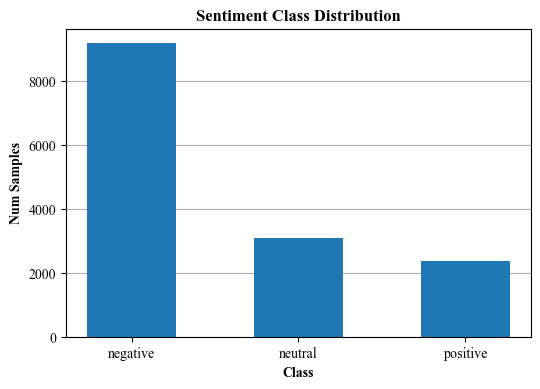

In [4]:
# Encoding the labels
cls_names, cls_counts = np.unique(data["airline_sentiment"], return_counts=True)

fig, ax = plt.subplots(
    1,
    figsize=(6, 4),
)
x = np.linspace(start=1, stop=2.5, num=3)
ax.bar(x, cls_counts, 0.4, zorder=2)
ax.set_xticks(x, labels=cls_names)
ax.set_xlabel("Class", fontweight="bold")
ax.set_ylabel("Num Samples", fontweight="bold")
ax.grid(axis="y", zorder=1)
ax.set_title("Sentiment Class Distribution", fontweight="bold")
plt.show()

In [5]:
# Checking counts of classes
print(list(zip(cls_names, cls_counts)))

[('negative', 9178), ('neutral', 3099), ('positive', 2363)]


Heavily skewed towards negative sentiment.

In [6]:
data["text"][:10].values

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it",
       "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
       '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
       '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
       "@virginamerica Well, I didn't…but NOW I DO! :-D",
       "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."],
      dtype=object)

In [7]:
for _, v in enumerate(
    zip(data["airline_sentiment"][:10].values, data["text"][:10].values)
):
    print(v)

('neutral', '@VirginAmerica What @dhepburn said.')
('positive', "@VirginAmerica plus you've added commercials to the experience... tacky.")
('neutral', "@VirginAmerica I didn't today... Must mean I need to take another trip!")
('negative', '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse')
('negative', "@VirginAmerica and it's a really big bad thing about it")
('negative', "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA")
('positive', '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)')
('neutral', '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP')
('positive', "@virginamerica Well, I didn't…but NOW I DO! :-D")
('positive', "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.")


In [8]:
labels = (
    data["airline_sentiment"]
    .replace({"negative": 0, "neutral": 1, "positive": 2})
    .values
)

labels

array([1, 2, 1, ..., 1, 0, 1], dtype=int64)

## Removing words/stemming

In [9]:
# Rebuilding the corpus for token extraction

stop_words = stopwords.words("english")
stemmer = PorterStemmer()

patterns = [
    r"http\S+",  # Get rid of links
    r"@\S+",  # Get rid of mentions
    r"\n",  # Get rid of newline chars
    r"0x\S+",  # Get rid of weird unicode byte strings
]

pattern = "|".join("(%s)" % p for p in patterns)
rm_reg = re.compile(pattern)


def stop_removal(w):
    if w not in stop_words:
        return True
    else:
        return False


def perform_preprocessing(regex=True, stop=True, stem=True):
    corpus = []
    for i, tweet in data["text"].items():
        if regex:
            tweet = rm_reg.sub("", tweet.lower())

        words = re.findall("\w+", tweet)

        if stop:
            words = filter(stop_removal, words)

        if stem:
            words = [stemmer.stem(word) for word in words]

        corpus.append([w for w in words])

    return corpus


unalt_corpus = perform_preprocessing(regex=False, stop=False, stem=False)

print(unalt_corpus[:5])

[['VirginAmerica', 'What', 'dhepburn', 'said'], ['VirginAmerica', 'plus', 'you', 've', 'added', 'commercials', 'to', 'the', 'experience', 'tacky'], ['VirginAmerica', 'I', 'didn', 't', 'today', 'Must', 'mean', 'I', 'need', 'to', 'take', 'another', 'trip'], ['VirginAmerica', 'it', 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'faces', 'amp', 'they', 'have', 'little', 'recourse'], ['VirginAmerica', 'and', 'it', 's', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']]


In [10]:
alt_corpus = perform_preprocessing()
print(alt_corpus[:5])

[['said'], ['plu', 'ad', 'commerci', 'experi', 'tacki'], ['today', 'must', 'mean', 'need', 'take', 'anoth', 'trip'], ['realli', 'aggress', 'blast', 'obnoxi', 'entertain', 'guest', 'face', 'amp', 'littl', 'recours'], ['realli', 'big', 'bad', 'thing']]


## Tokenizing

In [12]:
from keras.preprocessing.text import Tokenizer
# Constructing the tokenizer and word index
def build_tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    # + 1 accounts for any unknown/null words
    dict_size = len(tokenizer.word_index) + 1

    print(f"Dictionary size {dict_size} words")
    print(f"across {len(corpus)} tweets.")

    return tokenizer, dict_size


unalt_tokenizer, unalt_size = build_tokenizer(unalt_corpus)
alt_tokenizer, alt_size = build_tokenizer(alt_corpus)

Dictionary size 15090 words
across 14640 tweets.
Dictionary size 10275 words
across 14640 tweets.


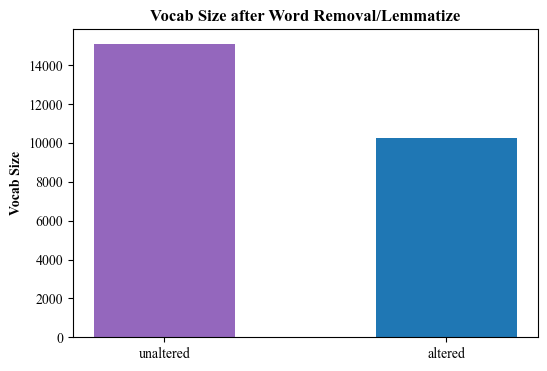

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 4))
rect1 = ax.bar([0], [unalt_size], width=0.5, color="tab:purple")
rect2 = ax.bar([1], [alt_size], width=0.5, color="tab:blue")
plt.title("Vocab Size after Word Removal/Lemmatize", fontweight="bold")
plt.ylabel("Vocab Size", fontweight="bold")
ax.set_xticks([0, 1], labels=["unaltered", "altered"])
plt.show()

In [14]:
# Performing tokenization and padding
def tokenize(tokenizer, corpus):
    # Tokenize
    input_sequences = []
    new_labels = []
    for i, tweet in enumerate(corpus):
        tokens = tokenizer.texts_to_sequences([tweet])[0]
        if len(tokens) == 0:
            tokens = [len(tokenizer.word_index) + 1]
        input_sequences.append(tokens)

        if i < 3:
            print(tweet)
            print(tokens, "\n")

    # Pad
    max_len = max([len(x) for x in input_sequences])
    print(f"Longest tweet length: {max_len}")
    return input_sequences


unalt_input = tokenize(unalt_tokenizer, unalt_corpus)

['VirginAmerica', 'What', 'dhepburn', 'said']
[81, 52, 6505, 227] 

['VirginAmerica', 'plus', 'you', 've', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']
[81, 553, 5, 90, 1139, 2479, 1, 3, 202, 6506] 

['VirginAmerica', 'I', 'didn', 't', 'today', 'Must', 'mean', 'I', 'need', 'to', 'take', 'another', 'trip']
[81, 2, 203, 11, 100, 776, 573, 2, 78, 1, 157, 151, 194] 

Longest tweet length: 35


In [15]:
alt_input = tokenize(alt_tokenizer, alt_corpus)

['said']
[139] 

['plu', 'ad', 'commerci', 'experi', 'tacki']
[433, 519, 1046, 114, 4831] 

['today', 'must', 'mean', 'need', 'take', 'anoth', 'trip']
[40, 620, 260, 17, 50, 82, 106] 

Longest tweet length: 25


# 2. Preparing the Data

## 2.1 Loading Torch modules

In [95]:
import torch
import torch.utils.data as D
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import (
    pack_sequence,
    unpack_sequence,
    pad_sequence,
    unpad_sequence,
)

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32

## 2.2 Dataset Class

In [155]:
def transform_pad(x):
    """Required for embeddings. Pads all sequences to max length."""
    new_x = []
    for sample in x:
        # Unsqueeze here just adds another dimension at dim=1
        # Effectively this is saying that we have T timesteps with 1 feature
        _sample = torch.tensor(sample, device=DEVICE, dtype=torch.long)
        new_x.append(_sample)

    # Pad
    new_x = pad_sequence(new_x, batch_first=True)
    return new_x


def transform_pack(x):
    """Required for encoded sequence"""
    lengths = list(map(len, alt_input))
    max_len = max(lengths)
    return


def target_transform(y):
    new_y = []
    for target in y:
        _target = torch.tensor(target, device=DEVICE).long() # One hot only works on long() data type
        new_y.append(F.one_hot(_target, num_classes=3).half()) # Convert to float16 to compute loss later

    return new_y


class AirlineData(D.Dataset):
    def __init__(
        self,
        data: list,
        targets: list,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        super().__init__()
        self.data = transform(data) if transform else data
        self.targets = target_transform(targets) if target_transform else targets
        self.num_classes = np.unique(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.targets[idx])


alt_airline_data = AirlineData(alt_input, labels, transform_pad, target_transform)
#unalt_airline_data = AirlineData(unalt_input, labels, transform_pad, target_transform)

## 2.3 Setting up DataLoaders

In [157]:
rand_gen = torch.Generator().manual_seed(192)
train, val, test = D.random_split(alt_airline_data, [0.7, 0.15, 0.15], generator=rand_gen)

# Data loaders
train_loader = D.DataLoader(train, 1024, shuffle=True)
val_loader = D.DataLoader(val, 1024)
test_loader = D.DataLoader(test, 1024)

# 3. Training

## 3.1 Model Class

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        padded_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_classes: int,
    ) -> torch.tensor:
        super().__init__()
        self._num_classes = num_classes

        self._embedding = nn.Embedding(
            vocab_size + 1, embedding_dim, padding_idx=0, norm_type=2.0
        )
        self._batchnorm = nn.BatchNorm1d(padded_size)
        self._gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self._ff = nn.Linear(hidden_dim, hidden_dim // 2)
        self._out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        _x = self._embedding(x)
        #_x = self._batchnorm(_x)
        # Take only the final hidden state of GRU
        _, _x = self._gru(_x)
        # Tanh happens automatically after GRU
        _x = F.dropout(_x, p=0.15)
        _x = self._ff(_x)
        _x = F.relu(_x, inplace=True)
        _x = F.dropout(_x, p=0.1)
        _x = self._out(_x)
        pred = F.softmax(_x, dim=-1).squeeze(0)
        return pred

    def get_embedding(self):
        return self._embedding.weight
    
    @property
    def num_parameters(self):
        total_param = 0
        for p in self.parameters():
            total_param += len(p.ravel())
        
        return total_param
        




EmbeddingModel(
  (_embedding): Embedding(10288, 100, padding_idx=0)
  (_batchnorm): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_gru): GRU(100, 64, batch_first=True)
  (_ff): Linear(in_features=64, out_features=32, bias=True)
  (_out): Linear(in_features=32, out_features=3, bias=True)
)

In [235]:
em.num_parameters

1062901

In [236]:
for i, (data, label) in enumerate(train_loader):
    print(em(data))
    break

tensor([[0.3488, 0.3132, 0.3380],
        [0.3509, 0.3132, 0.3359],
        [0.3541, 0.3177, 0.3283],
        ...,
        [0.3319, 0.3224, 0.3457],
        [0.3383, 0.3170, 0.3446],
        [0.3424, 0.3127, 0.3449]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [244]:
from math import ceil
from IPython.display import clear_output
from torchmetrics import Accuracy


def train_model(
    model: nn.Module,
    train_loader: D.DataLoader,
    val_loader: D.DataLoader,
    optimizer,
    criterion,
    epochs=100,
):
    history = {"train": [], "val": []}
    num_train_batches = ceil(len(train_loader.dataset) / train_loader.batch_size)
    num_val_batches = ceil(len(val_loader.dataset) / val_loader.batch_size)
    mca_train = Accuracy(task="multiclass", num_classes=model._num_classes).to(
        device=DEVICE
    )
    mca_val = mca_train.clone()

    for epoch in range(epochs):
        sum_train_loss = 0
        for step, (train_batch, train_labels) in enumerate(train_loader):
            ###########
            # Forward #
            ###########
            model.train()
            preds = model(train_batch)

            ###################
            # Compute Metrics #
            ###################
            train_loss = criterion(preds, train_labels)
            model.eval()
            with torch.inference_mode():
                # train_acc = compute_acc(preds, train_labels)
                train_acc = mca_train.forward(
                    preds.to(torch.float16), torch.argmax(train_labels, dim=1)
                )

                sum_train_loss += train_loss.item()
            
            ###############
            # Make output #
            ###############
            num_bars = int(((step / num_train_batches) * 20)) + 1
            completion_string = "=" * num_bars
            completion_string += "-" * (20 - num_bars)
            output = (
                "Epoch: {} \t [{}] \t Train loss: {:.3f} \t Train acc: {:.3f}".format(
                    epoch,
                    completion_string,
                    sum_train_loss / (step + 1),
                    mca_train.compute().item(),
                )
            )
            print(output, end="\r")

            #################
            # Backpropogate #
            #################
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        avg_train_loss = sum_train_loss / num_train_batches

        ##############
        # Validation #
        ##############
        model.eval()  # Turn off batch norm
        with torch.inference_mode():
            sum_val_loss = 0
            for _, (val_batch, val_labels) in enumerate(val_loader):
                preds = model(val_batch)
                targets = val_labels

                val_loss = criterion(preds, targets)
                sum_val_loss += val_loss.item()

                mca_val.update(preds.to(torch.float16), torch.argmax(targets, dim=1))

            avg_val_loss = sum_val_loss / num_val_batches

            print(
                "\nAvg Train Loss: {:.3f}\
                Avg Val Loss: {:.3f}\
                Avg Train Acc: {:.3f}\
                Avg Val Acc: {:.3f}".format(
                    avg_train_loss,
                    avg_val_loss,
                    mca_train.compute().item(),
                    mca_val.compute().item(),
                )
            )

            print("-" * 140, "\n")

        mca_train.reset()
        mca_val.reset()

        ##########
        # Record #
        ##########
        history["train"].append(avg_train_loss)
        history["val"].append(avg_val_loss)

    return history

In [325]:
vocab_size = torch.max(alt_airline_data.data) + 1
padded_size = alt_airline_data.data.shape[-1]

model = EmbeddingModel(
    vocab_size, padded_size, embedding_dim=100, hidden_dim=32, num_classes=3
)
model.to(device=DEVICE, dtype=DTYPE)

print(f"{model.num_parameters:,}")

1,042,293


In [326]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

hist = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=500)

Epoch: 0 	 [===================-] 	 Train loss: 1.068 	 Train acc: 0.633
Avg Train Loss: 1.068                Avg Val Loss: 1.068                Avg Train Acc: 0.633                Avg Val Acc: 0.619
-------------------------------------------------------------------------------------------------------------------------------------------- 

Epoch: 1 	 [===================-] 	 Train loss: 1.057 	 Train acc: 0.633
Avg Train Loss: 1.057                Avg Val Loss: 1.058                Avg Train Acc: 0.633                Avg Val Acc: 0.619
-------------------------------------------------------------------------------------------------------------------------------------------- 

Epoch: 2 	 [===================-] 	 Train loss: 1.047 	 Train acc: 0.633
Avg Train Loss: 1.047                Avg Val Loss: 1.044                Avg Train Acc: 0.633                Avg Val Acc: 0.619
------------------------------------------------------------------------------------------------------------------

KeyboardInterrupt: 

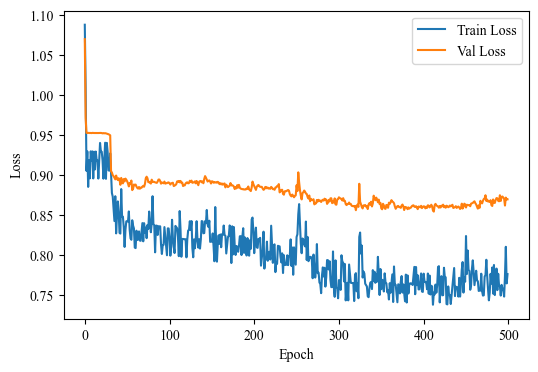

In [327]:
train_loss, val_loss = hist["train"], hist["val"]
epochs = np.arange(len(train_loss))
fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(epochs, train_loss, label="Train Loss")
ax.plot(epochs, val_loss, label="Val Loss")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

## 3.2 Evaluating on the Test Set

In [328]:
mca_test = Accuracy(
    task="multiclass",
    num_classes=3).to(device=DEVICE)

for i, (data, label) in enumerate(test_loader):
    pred = model(data)
    mca_test.update(pred.to(torch.float16),
                    torch.argmax(label, dim=1)),

print("Test Accuracy: {:.3f}".format(mca_test.compute().item()))

Test Accuracy: 0.735


# 4. Visualizing the Embeddings

In [261]:
from sklearn.manifold import TSNE

tSNE = TSNE(n_components=2, perplexity=30, random_state=192)
embeddings = model.get_embedding().detach().cpu().numpy()

t_embed = tSNE.fit_transform(embeddings)

In [294]:
words = np.array(list(alt_tokenizer.word_index.keys()))
word_idx = np.array(list(alt_tokenizer.word_index.values()))

t_embed = t_embed[word_idx]

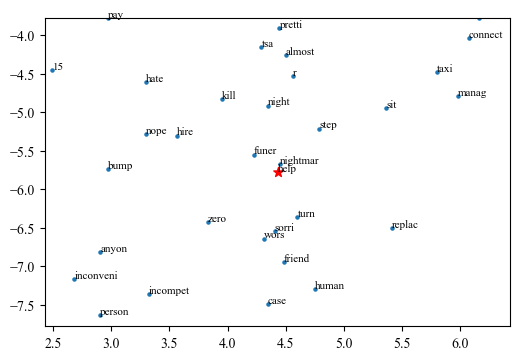

In [324]:
n_scale = 2
center = 5

fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(t_embed[:, 0][:1000], t_embed[:, 1][:1000], s=5)
ax.scatter(t_embed[center, 0], t_embed[center, 1], s=50, color="red", marker="*")
ax.set_xlim(t_embed[center, 0]-n_scale, t_embed[center, 0]+n_scale)
ax.set_ylim(t_embed[center, 1]-n_scale, t_embed[center, 1]+n_scale)

for point, word in zip(t_embed[:1000], words[:1000]):
    ax.annotate(
        word,
        xy=(point[0], point[1]),
        xytext=(point[0], point[1]+0.01),
        fontsize=8
    )

plt.show()